# Use Case: Aspect Term Exctractor

#### Description
Companies that provide services or products to their customers would like to know which aspects of their products are relevant to their customers. This knowledge will help to improve their products in the future. Are people talking mostly about the quality of the food, the price of an item or the battery life of a computer? All those terms are what we call "aspect terms".

This task can be solved using an Aspect Term Extractor. An ATE is a model that extracts the aspect terms from a review, i.e. for each word of one review, your model should predict if the word is an aspect term or not. Terms may consist of multiple words.

#### General Notes
This notebook addresses the following 3 topics:

- The features extraction process: What is the intuition behind your method, which features are the most important.
- The algorithm you selected (we ask you to explore at least 2 different algorithms)
- The metric that you used for quantifying the performance of your model

We use the term 'predict' and 'extract' interchangably.

#### Dependencies

In the process of creating this notebook, the following libraries were used:

seaborn
numpy
pandas
matplotlib
scikit-learn
sklearn-crfsuite


#### References
- https://www.aclweb.org/anthology/S/S14/S14-2038.pdf
- https://www.thinkmind.org/download.php?articleid=data_analytics_2017_5_20_60030
- http://nlpforhackers.io/training-pos-tagger/
- http://www.albertauyeung.com/post/python-sequence-labelling-with-crf/

In [1]:
%matplotlib inline
%precision 3

import pandas as pd
import seaborn as sns
import numpy as np
import re

def sanitize(text):
    '''
    Basic pre-processing. Replaces the non-breakable space control character.
    '''
    return re.sub(u'\xa0', u' ', text)

### Reading the data
The train and test data is stored as in two XML files. The files are located in the same folder as this notebook:

In [2]:
!ls *.xml

Laptops_Test_Gold.xml Laptops_Train_v2.xml


This is the function to read in the data from the XML files. It uses the standard XML library available in Python. As the data size is neglibly small, we simply read the whole file into memory.

In [3]:
from lxml import etree

def parse_xml(filename):
    with open(filename, 'rb') as f:
        xml = f.read()
        
    tree = etree.fromstring(xml)
    
    sentences = []
    for sentence in tree:
        sentence_data = { 'terms' : [] }
        for data in sentence:
            if data.tag == 'text':
                sentence_data['text'] = sanitize(data.text)
            if data.tag == 'aspectTerms':
                for term in data:
                    t = dict(term.attrib)
                    t['term'] = sanitize(t['term'])
                    sentence_data['terms'].append(t)
        sentences.append(sentence_data)
    return sentences
        
train = parse_xml('Laptops_Train_v2.xml')
test  = parse_xml('Laptops_Test_Gold.xml')

Having successfully parsed the XML, we end up with a nested data-structure with the main components being "text" and "terms". We saved the data under `train` and `test`.

In [4]:
import json
print(json.dumps(train[0], indent=4))

{
    "terms": [
        {
            "term": "cord",
            "polarity": "neutral",
            "from": "41",
            "to": "45"
        },
        {
            "term": "battery life",
            "polarity": "positive",
            "from": "74",
            "to": "86"
        }
    ],
    "text": "I charge it at night and skip taking the cord with me because of the good battery life."
}


The main data fields are:
- text: The plain text of the review
- terms: The annoated list of terms present in the review

In order to ease further analysis, we convert the data into a Pandas DataFrame.

In [5]:
terms_train = [[sanitize(t['term']) for t in x['terms']] for x in train]
texts_train = [sanitize(t['text']) for t in train]
df_train = pd.DataFrame({'terms': terms_train, 'text': texts_train})
df_train['num_terms'] = df_train.terms.apply(len)

terms_test = [[sanitize(t['term']) for t in x['terms']] for x in test]
texts_test = [sanitize(t['text']) for t in test]
df_test = pd.DataFrame({'terms': terms_test, 'text': texts_test})
df_test['num_terms'] = df_test.terms.apply(len)

## Basic Data Exploration

Here's the data that we're working with:

In [6]:
pd.set_option('display.max_colwidth', 256) # let's see the full text
df_train.head(10)

,terms,text,num_terms
0,"[cord, battery life]",I charge it at night and skip taking the cord with me because of the good battery life.,2
1,[],I bought a HP Pavilion DV4-1222nr laptop and have had so many problems with the computer.,0
2,"[service center, ""sales"" team, tech guy]","The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the ""sales"" team, which is the retail shop which I bought my netbook from.",3
3,[],I investigated netbooks and saw the Toshiba NB305-N410BL.,0
4,[],"The other day I had a presentation to do for a seminar at a large conference in town- lots of people, little time to prep and have to set up a computer to a projector, etc.",0
5,"[quality, GUI, applications, use]","it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous.",4
6,[start up],Easy to start up and does not overheat as much as other laptops.,1
7,[],Sad very SAD.,0
8,"[features, iChat, Photobooth, garage band]","I even got my teenage son one, because of the features that it offers, like, iChat, Photobooth, garage band and more!",4
9,[],Needless to say a PC that can't support a cell phone is less than useless!,0


### Top 10 most common terms by count

#### Top 10 in the training set

In [7]:
terms_train = pd.Series(np.concatenate(df_train.terms.values))
term_counts_train = terms_train.value_counts()
term_counts_train.head(10)

screen          58
price           55
use             53
battery life    52
battery         45
keyboard        43
programs        36
software        33
features        32
warranty        31
dtype: int64

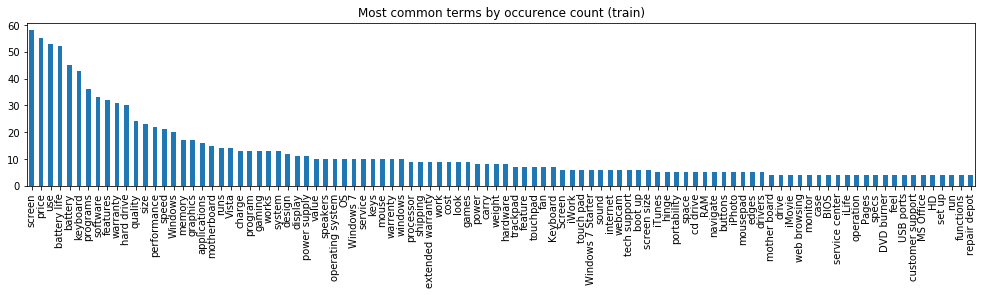

In [8]:
term_counts_train.head(100).plot(kind='bar', figsize=(17, 3), title='Most common terms by occurence count (train)')

#### Top 10 in the test set

In [9]:
terms_test = pd.Series(np.concatenate(df_test.terms.values))
term_counts_test = terms_test.value_counts()
term_counts_test.head(10)

price          17
works          13
features       12
OS             12
performance    12
size            9
Windows 8       9
use             9
screen          8
battery         6
dtype: int64

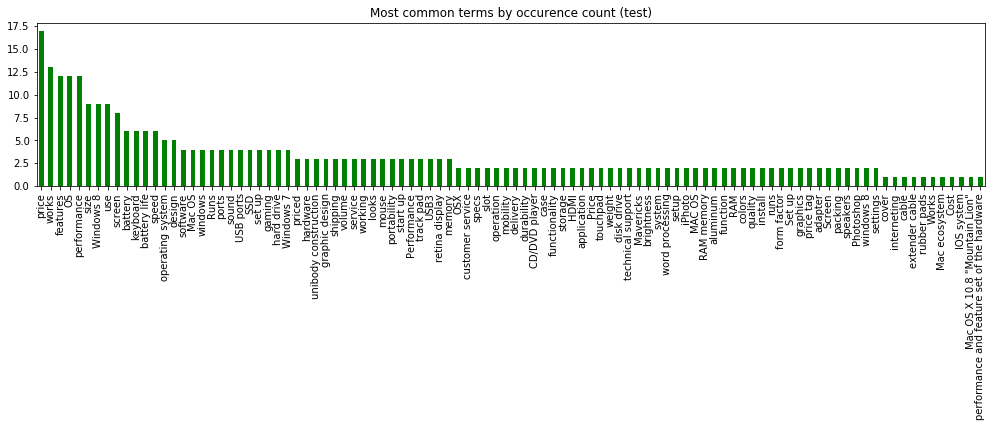

In [10]:
term_counts_test.head(100).plot(kind='bar', figsize=(17, 3), color='green', title='Most common terms by occurence count (test)')

### Spelling errors and non-standardized terms

In [11]:
print(terms_train[terms_train.str.match('^war.*$')].str.split().str.get(0).unique())

['warranty' 'warrenty' 'warrentys']


In [12]:
print(terms_train[terms_train.str.contains('sales')].unique())

['"sales" team' 'sales associate' 'sales' 'sales tax' 'after sales support'
 'after sales service']


#### Common terms related to 'Windows' in the training set

In [13]:
terms_train[terms_train.str.match('^windows')].value_counts()

windows                   10
windows 7                  3
windows xp                 1
windows media              1
windows logon              1
windows 7 home premium     1
windows OS                 1
windows 7 system           1
windows vista system       1
windows disc               1
windows vista              1
windows movie maker        1
windows system             1
dtype: int64

#### Common terms related to 'Windows' in the test set

In [14]:
terms_test[terms_test.str.lower().str.match('^windows')].value_counts()

Windows 8           9
Windows 7           4
windows             4
windows 8           2
windows XP          1
Windows updates     1
windows 7           1
Windows 8 Set-Up    1
Windows             1
windows Vista       1
dtype: int64

### How many unique terms do we have in the training and the test set, respectively?

In [15]:
terms_train.str.lower().nunique(), terms_test.str.lower().nunique()

(955, 393)

### How many terms are in the test set, but not in the train_set?

In [16]:
unknown_terms = terms_test[~terms_test.isin(terms_train)]
unknown_terms.nunique()

267

### Total number of terms which are present train and test

In [17]:
terms_test.isin(terms_train).value_counts()
# True if the term is in the train set
# False if the given term is not in the train set

True     354
False    300
dtype: int64

That means, 300 terms (~45%) are not in the training set.

### What are the top terms that are present in the test set, but not in the train set?

In [18]:
terms_test[~terms_test.isin(terms_train)].value_counts().head(10)

Windows 8               9
SSD                     4
graphic design          3
USB3                    3
unibody construction    3
retina display          3
settings                2
mobility                2
Mavericks               2
aluminum                2
dtype: int64

### What does the distribution of the number terms look like?

Looking at the training data, most reviews (close to 1500 reviews) don't have an associated term.

- 930 review have exactly 1 term
- 354 reviews have 2 terms

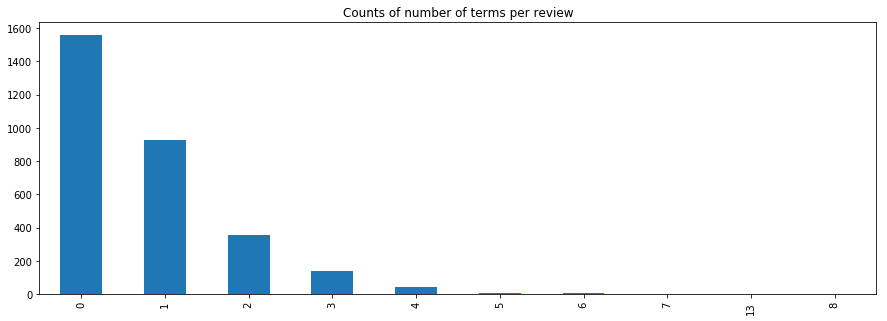

In [19]:
df_train.num_terms.value_counts().plot(kind='bar', title='Counts of number of terms per review', figsize=(15, 5))

In [20]:
df_train.num_terms.value_counts()

0     1557
1      930
2      354
3      140
4       43
5       10
6        6
7        3
13       1
8        1
Name: num_terms, dtype: int64

#### Observations
- Most reviews have no associated terms.
- 1-4 terms per review are common, more than 4 terms seems to be the exception.

There is one review, which is associated with 13(!) terms. Let's take a look at it:

In [21]:
df_train[df_train.num_terms == 13]

,terms,text,num_terms
655,"[programs, Garageband, Photo Booth, iPhoto, iMovie, video-editing, movie-making, photo management, music, Pages, Numbers, Keynote, school or office use]","There are several programs for school or office use (Pages, Numbers, Keynote, etc.), music (Garageband), photo management (Photo Booth, iPhoto), video-editing or movie-making (iMovie), etc.",13


Let's look at a more common case with 1 term only:

In [22]:
df_train[df_train.num_terms == 1].head()

,terms,text,num_terms
6,[start up],Easy to start up and does not overheat as much as other laptops.,1
10,[features],Great laptop that offers many great features!,1
14,[battery],I took it back for an Asus and same thing- blue screen which required me to remove the battery to reset.,1
23,[suite of software],I love the way the entire suite of software works together.,1
24,[speed],The speed is incredible and I am more than satisfied.,1


## Pre-processing

As suggested in the use case description, we will convert the data into the BIO representation. So let's start with some code to bring our data into a suitable representation for the input to a machine learning model:

In [23]:
def term_to_placeholder(term):
    '''
    Converts a term to the representation enlarged BIO representation format.
    
    O = not an aspect (Outside)
    B = first word of an aspect term(Beginning)
    I = second, third, ... word of an aspect term (Inside)
    
    Example inputs and outputs:
        "audio" -> "BBBBB"
        "cd player" -> "BB IIIII"
        "windows 8" -> "BBBBBBB I"
        "foo bar" -> "BBB III"
    '''
    parts = term.split(' ')
    if len(parts) == 0:
        return ''
    
    first = ['B'*len(parts[0])]
    last = ['I'*len(t) for t in parts[1:]]
    return ' '.join(first + last) 

for terms in df_train.terms[0:20]:
    if len(terms) == 0:
        continue
    for t in terms:
        print(t, '->', term_to_placeholder(t))

cord -> BBBB
battery life -> BBBBBBB IIII
service center -> BBBBBBB IIIIII
"sales" team -> BBBBBBB IIII
tech guy -> BBBB III
quality -> BBBBBBB
GUI -> BBB
applications -> BBBBBBBBBBBB
use -> BBB
start up -> BBBBB II
features -> BBBBBBBB
iChat -> BBBBB
Photobooth -> BBBBBBBBBB
garage band -> BBBBBB IIII
features -> BBBBBBBB
GUI -> BBB
screen -> BBBBBB
power light -> BBBBB IIIII
hard drive light -> BBBB IIIII IIIII
battery -> BBBBBBB
rubber enclosure -> BBBBBB IIIIIIIII
edge -> BBBB
multi-touch gestures -> BBBBBBBBBBB IIIIIIII
tracking area -> BBBBBBBB IIII
external mouse -> BBBBBBBB IIIII
gaming -> BBBBBB


The following code converts a review to a raw annotated placeholder representation. Also replaces
every occurence of terms with the corresponding term representation in the review.

The review is expected to have a 'text' and a list of terms stored under the key 'terms'.

**Example input data structure:**

    {
    'text': 'Built-in apps are cool!',
    'terms' : [{'term': 'Built-in apps', 'from': '0', 'to': '13'}]
    }

**Example Input/Output:**

    I charge it at night and skip taking the cord with me because of the good battery life.
    O OOOOOO OO OO OOOOO OOO OOOO OOOOOO OOO BBBB OOOO OO OOOOOOO OO OOO OOOO BBBBBBB IIII
                                             ^^^^                             ^^^^^^^ ^^^^

In [24]:
import re

def review_to_placeholder(review):
    '''
    Converts a review to a raw annotated placeholder representation. Also replaces
    every occurence of terms with the corresponding term representation in the review.
    
    The review is expected to have a 'text' and a list of terms stored under the key 'terms'.
    
    Example data structure:
    
    {
    'text': 'Built-in apps are cool!',
    'terms' : [{'term': 'Built-in apps', 'from': '0', 'to': '13'}]
    }
    
    Example Input/Output:
    
    I charge it at night and skip taking the cord with me because of the good battery life.
    O OOOOOO OO OO OOOOO OOO OOOO OOOOOO OOO BBBB OOOO OO OOOOOOO OO OOO OOOO BBBBBBB IIII
                                             ^^^^                             ^^^^^^^ ^^^^
    '''
    placeholders = re.sub('[^ .!?,\(\)]', 'O', review['text'])

    for t in review['terms']:
        a, b = int(t['from']), int(t['to'])
        #print('BEFORE:', placeholders, a, b, review['text'][a:b])
        placeholders = placeholders[:a] + term_to_placeholder(t['term']) + placeholders[b:]
        #print('AFTER :', placeholders)
    return placeholders

for i in [0, 2, 12, 123]:
    review = train[i]
    print('---------------------------')
    print('INPUT :', review['text'])
    print('OUTPUT:', review_to_placeholder(review))
    print([t['term'] for t in review['terms']])

---------------------------
INPUT : I charge it at night and skip taking the cord with me because of the good battery life.
OUTPUT: O OOOOOO OO OO OOOOO OOO OOOO OOOOOO OOO BBBB OOOO OO OOOOOOO OO OOO OOOO BBBBBBB IIII.
['cord', 'battery life']
---------------------------
INPUT : The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the "sales" team, which is the retail shop which I bought my netbook from.
OUTPUT: OOO BBBB III OOOO OOOO OOO BBBBBBB IIIIII OOOO OOO OO OOOOOO OOOOOOOO OOO O OOOO OO OOOOOO OO OOOOOOO OO OOO BBBBBBB IIII, OOOOO OO OOO OOOOOO OOOO OOOOO O OOOOOO OO OOOOOOO OOOO.
['service center', '"sales" team', 'tech guy']
---------------------------
INPUT :  One night I turned the freaking thing off after using it, the next day I turn it on, no GUI, screen all dark, power light steady, hard drive light steady and not flashing as it usually does.
OUTPUT:  OOO OOOOO O OOOOOO OOO OOOOOOOO OOOOO OOO OOOOO OOOOO OO, OOO OOOO 

In [25]:
placeholders = review_to_placeholder({
    'text': 'Built-in apps are cool!',
    'terms' : [{'term': 'Built-in apps', 'from': '0', 'to': '13'}]
})
assert placeholders == 'BBBBBBBB IIII OOO OOOO!', 'placeholders not working, got {}'.format(placeholders)

### Converting the raw format to the tokenized version

#### Tokenized format

The last pre-processing step involves the actual tokenization of the input. We apply this to the original review text and to the raw BIO represantation, respectively.

In [26]:
SPLIT_PATTERN = r'[ ,!?\(\)]+'
def split(text):
    '''
    Splits a string on whitespaces while ignoring punctuation [.!?,]
    and removes empty tokens.
    '''
    text = re.sub('([.,])+', r'\1', text) # condense multiple occurrences '...' -> '.'
    text = re.sub(' , ', ', ', text) # "foo , bar" -> "foo, bar"
    text = re.sub(' \.', '.', text) # "Blanks before full stop ." -> "Blanks before full stop."
    tokens = [re.sub('[.,]$', '', t).strip() for t in re.split(SPLIT_PATTERN, text)]
    return [t for t in tokens if len(t) > 0] # as a last step, we filter empty strings ''

from spacy import tokenizer
tokenizer

def test_split(text):
    print('|'.join(split(text)))

test_split('Data cleansing... is a lot of fun...,, you know?')
test_split('I have now had it for 1.5 months and love it.')
test_split('We should do this.')
test_split('I got my mac, but sent it back,,,,,eventually')
test_split('The Apple MC371LL/A 2.4Ghz 15.4-inch MacBook Pro')
test_split('I have my laptop for 1.5 months now')
test_split('I am using the external speaker- sound is good.')
test_split('It is a big big, but since it has a 18.4" screen what would you expect!')

Data|cleansing|is|a|lot|of|fun|you|know
I|have|now|had|it|for|1.5|months|and|love|it
We|should|do|this
I|got|my|mac|but|sent|it|back|eventually
The|Apple|MC371LL/A|2.4Ghz|15.4-inch|MacBook|Pro
I|have|my|laptop|for|1.5|months|now
I|am|using|the|external|speaker-|sound|is|good
It|is|a|big|big|but|since|it|has|a|18.4"|screen|what|would|you|expect


In [27]:
def annotate(review):
    '''
    Takes as an input a review and tokenizes and annotates the text.
    
    Example input/output:
    "I charge it" -> [('I', 'O'), ('charge', 'B'), ('it', 'O'), ... ]
    '''
    placeholders = review_to_placeholder(review)
    for token in ['O', 'I', 'B']:
        placeholders = re.sub(token + '+', token, placeholders)
    
    # [('I', 'B'), ('charge', 'I'), ('it', 'O'), ... ]
    l1 = split(review['text'])
    l2 = [l[0] for l in split(placeholders)] # FIXME: This is still a work-around, need better tokenization
    if len(l1) != len(l2):
        print(review['text'])
        print(review_to_placeholder(review))
        print(len(l1), l1)
        print(len(l2), l2)
        raise ValueError('Tokenization error.')
    tokens = zip(l1, l2)
    
    #assert all(x in ['O', 'I', 'B'] for x in l2), 'Invalid tokens found in {}'.format(l2)
    return list(tokens)

annotate(train[124])

[('I', 'O'),
 ('am', 'O'),
 ('using', 'O'),
 ('the', 'O'),
 ('external', 'B'),
 ('speaker-', 'I'),
 ('sound', 'B'),
 ('is', 'O'),
 ('good', 'O')]

### Make sure we have no tokenization violations

This is just a sanity check to ensure we are not creating invalid token representations e.g. 'OO', 'I.O' or 'BO'.

In [28]:
tokens_train = [annotate(review) for review in train]
invalid_tokens = [[t[1] for t in review if not (t[1] in ['O', 'I', 'B'])] for review in tokens_train]
report = pd.DataFrame({
    'text'   : [t['text'] for t in train],
    'offenders' : invalid_tokens,
    'valid'  : [len(ts) == 0 for ts in invalid_tokens]
})

print(report[~report.valid].shape[0], 'token violations...')
if report[~report.valid].shape[0] > 0:
    print(report[~report.valid])

0 token violations...


In [29]:
report[~report.valid].offenders.astype(str).value_counts()

Series([], Name: offenders, dtype: int64)

## Feature Engineering

In [30]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def tokens_to_feature(words, i):
    '''
    Creates a feature vector for the i-th word from list of tokenized words.
    '''
    w = [w for w in words]

    return { 'word' : w[i],
             'word-2' : w[i - 2] if i > 1 else '',
             'word-1' : w[i - 1] if i > 0 else '',
             'word+1' : w[i + 1] if i < (len(w) - 1) else '',
             'word+2' : w[i + 2] if i < (len(w) - 2) else '',
             'is-upper' : w[i].isupper(),
             'is-lower' : w[i].islower(),
             'is-title' : w[i].istitle(),
             'is-digit' : w[i].isdigit(),
             'is-single-digit': w[i].isdigit() and len(w[i]) == 1,
             'pattern' : re.sub('\d+', '#', w[i]) if re.match('\W', w[i]) else '', # 15.3" -> #.#"
             'has-dash': '-' in w[i],
             'has-quotation': '"' in w[i],
             'is-stop-word': w[i] in ENGLISH_STOP_WORDS,
             'prefix-1': w[i][0],
             'prefix-2': w[i][:2],
             'prefix-3': w[i][:3],
             'suffix-1': w[i][-1],
             'suffix-2': w[i][-2:],
             'suffix-3': w[i][-3:],
             'capitals-inside': w[i][1:].lower() != w[i][1:],
             'word-rel-offest': i / len(words),
             'word-len' : len(w[i]), # FIXME may need standardization
             'is-first' : i == 0,
             'is-last' : i == (len(w) - 1)
    }

def sentence_to_feature(sentence):
    '''
    Converts a sentence into a feature representation suitable
    as the input to a machine learning model.
    '''
    tokens = split(sentence)
    return [tokens_to_feature(tokens, i) for i in range(len(tokens))]

for i, t in enumerate(train):
    try:
        sentence_to_feature(t['text'])
    except:
        print(i, t['text'])

print(train[0]['text'])
sentence_to_feature(train[0]['text'])[0:5]

I charge it at night and skip taking the cord with me because of the good battery life.


[{'capitals-inside': False,
  'has-dash': False,
  'has-quotation': False,
  'is-digit': False,
  'is-first': True,
  'is-last': False,
  'is-lower': False,
  'is-single-digit': False,
  'is-stop-word': False,
  'is-title': True,
  'is-upper': True,
  'pattern': '',
  'prefix-1': 'I',
  'prefix-2': 'I',
  'prefix-3': 'I',
  'suffix-1': 'I',
  'suffix-2': 'I',
  'suffix-3': 'I',
  'word': 'I',
  'word+1': 'charge',
  'word+2': 'it',
  'word-1': '',
  'word-2': '',
  'word-len': 1,
  'word-rel-offest': 0.000},
 {'capitals-inside': False,
  'has-dash': False,
  'has-quotation': False,
  'is-digit': False,
  'is-first': False,
  'is-last': False,
  'is-lower': True,
  'is-single-digit': False,
  'is-stop-word': False,
  'is-title': False,
  'is-upper': False,
  'pattern': '',
  'prefix-1': 'c',
  'prefix-2': 'ch',
  'prefix-3': 'cha',
  'suffix-1': 'e',
  'suffix-2': 'ge',
  'suffix-3': 'rge',
  'word': 'charge',
  'word+1': 'it',
  'word+2': 'at',
  'word-1': 'I',
  'word-2': '',
  'word-

## Modelling

### Data conversion to numerical representation

We use the well known scikit-learn machine learning library to predict the tokens and terms.

scikit-learn does not know how to deal with the dictionary-like structures we have from the feature engineering step. Therefore we make use of the DictVectorizer class to transform the input into a numerical representation, which can be fed to scikit-learns estimators.

In [31]:
from sklearn.feature_extraction import DictVectorizer

X_train = [sentence_to_feature(t['text']) for t in train]
X_test  = [sentence_to_feature(t['text']) for t in test]
y_train = np.asarray([[t[1] for t in annotate(review)] for review in train])

print('X_train, X_test shapes:', len(X_train), len(X_test))

X_train, X_test shapes: 3045 800


In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin

class Flattener(TransformerMixin):
    '''
    Helper class to flatten nested lists/arrays as a single continous list.
    [[1, 2], [3]] -> [1, 2, 3]
    '''
    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        return np.concatenate(X)

clf = make_pipeline(Flattener(), DictVectorizer(), LogisticRegression(C=100))

# This is how we would do hyper-parameter optimization.
# We leave it out for the sake of speed
if False:
    cv = GridSearchCV(estimator=clf,
                  param_grid=dict(
                        C=[0.1, 1, 10, 100, 1000],
                        penalty=['l1', 'l2'],
                        class_weight=['balanced', None]),
                  scoring='neg_log_loss',
                  n_jobs=-1,
                  verbose=1)

    cv.fit(np.concatenate(X_train), np.concatenate(y_train))
    clf = cv.best_estimator_
    cv.best_params_, cv.best_score_
else:
    clf.fit(X_train, np.concatenate(y_train)) # scikit-learn doesn't handle nested labels

### Helper functions

In the next section we build up helper functions to predict the sequence of tokens (`predict_tokens`).

We also add a function to predict all terms contained in a given sentence (`predict_terms`).

In [33]:
def predict_tokens(clf, sentence):
    '''
    Predicts BOI for a sequence of tokens.
    
    Example input/output:
      
      'Built-in apps are purely amazing.' -> ['O', 'B', 'O', 'O', 'O']
    
    '''
    x = sentence_to_feature(sentence)
    y_pred = clf.predict([x])
    return np.asarray(y_pred).reshape(-1) # CRF works with nested structers, scikit not.

def predict_terms(clf, sentence):
    '''
    For a given string (sentence) returns the term predictions as a list of terms.
    
    Example input/output:
    
      "The screen is huge" -> ["screen"]
      
    '''
    predictions = predict_tokens(clf, sentence)
    parts = split(sentence)
    terms = []
    in_term = False
    for i, (p, t) in enumerate(zip(predictions, parts)):
        if p == 'O':
            inTerm = False
            continue
        if p == 'B':
            terms.append(t)
            in_term = True
        if p == 'I':
            if not in_term:
                # OPEN POINT
                # The classifier sometimes returns 'I' (inside) as a standalone token
                # This is semantically incorrect and we need to find an adequate
                # solution to resolve the issue. Potential solutions include:
                # - Throw an error, but the model may not learn that dependency
                #   * raise ValueError('Invalid sequence of tokens OI: {}'.format(predictions))
                # - Handle it with a post-processing step and a to-be-defined heuristic
                # - Treat it as a stand-alone term
                #   * terms.append(t)
                # - Ignoring standalone 'I' terms
                #   * Given the limited time, we decied to just ignore them (also results
                #     in improved performance over treating them as stand-alone terms).
                continue
            else:
                terms[-1] = terms[-1] + ' ' + t
    return [t.lower() for t in terms]

def predict_review(clf, review):
    '''
    Helper method to quickly predict a specific review from the train or the test set.
    '''
    print('TEXT :', review['text'])
    print('TERMS:', [t['term'] for t in review['terms']])
    print('PRED :', predict_terms(clf, review['text']))

for i, review in enumerate(test[0:10]):
    if len(review['terms']) == 0:
        continue
    print('------- {} -------'.format(i))
    predict_review(clf, review)

------- 0 -------
TEXT : Boot time is super fast, around anywhere from 35 seconds to 1 minute.
TERMS: ['Boot time']
PRED : ['boot']
------- 1 -------
TEXT : tech support would not fix the problem unless I bought your plan for $150 plus.
TERMS: ['tech support']
PRED : ['tech support']
------- 3 -------
TEXT : Set up was easy.
TERMS: ['Set up']
PRED : ['set']
------- 4 -------
TEXT : Did not enjoy the new Windows 8 and touchscreen functions.
TERMS: ['Windows 8', 'touchscreen functions']
PRED : ['windows', 'touchscreen functions']
------- 6 -------
TEXT : Other than not being a fan of click pads (industry standard these days) and the lousy internal speakers, it's hard for me to find things about this notebook I don't like, especially considering the $350 price tag.
TERMS: ['internal speakers', 'price tag', 'click pads']
PRED : ['speakers', 'price tag']
------- 8 -------
TEXT : No installation disk (DVD) is included.
TERMS: ['installation disk (DVD)']
PRED : ['installation disk dvd']
-----

### Testing our prediction pipeline

Let's take them for a spin:

In [34]:
annotate(test[89])

[('Built-in', 'B'),
 ('apps', 'I'),
 ('are', 'O'),
 ('purely', 'O'),
 ('amazing', 'O')]

In [35]:
predict_tokens(clf, 'Built-in apps are purely amazing.')

array(['O', 'B', 'O', 'O', 'O'],
      dtype='<U1')

In [36]:
predict_review(clf, test[89])

TEXT : Built-in apps are purely amazing.
TERMS: ['Built-in apps']
PRED : ['apps']


### Evaluation of performance

#### Metric

For this problem we propose the micro-averaged F1-score on the evaluation metric on the extracted terms. Altough we internally use the BIO format to represent the problem, we believe it makes more sense from an end-user perspective to evaluate the performance on the final extracted terms. We also look at precision, recall and the Jaccard similarity independently and discuss the advantages and drawbacks, when optimizing these evaluation metrics.

https://www.kaggle.com/wiki/MeanFScore
https://en.wikipedia.org/wiki/Jaccard_index

In pattern recognition, information retrieval and binary classification, precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances. Both precision and recall are therefore based on an understanding and measure of relevance.

#### Quality through Precision:
- High precision: The terms retreived were relevant, but we are not sure if we catched all of them.
- Low precision: The terms retrieved were not relevant.

#### Quantity through Recall:
- High recall: Many relevant terms were retrieved.
- Low recall: Few of the relevant terms were retrieved.

Source: https://en.wikipedia.org/wiki/Precision_and_recall

#### Baselines
We first establish two base-line approaches for comparison.
- Constant prediction of the most common word 'screen'. (Baseline 1)
- Simple keyword matching based on the training set. (Baseline 2)

Then we we look at two more sophisticated approaches:
- Model based approach: Predicting the BIO-format and extract terms based on that prediction (Model)
- Combining keywords and model predictions (Keyword and Model)
- Dependency parsing using the Spacy library. (Spacy)

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_similarity_score

def score(y_test, y_pred):
    mlb = MultiLabelBinarizer()
    mlb.fit(y_pred + y_test)
    
    y_test = mlb.transform(y_test)
    y_pred = mlb.transform(y_pred)
    return {
        'f1': f1_score(y_test, y_pred, average='micro'),
        'precision': precision_score(y_test, y_pred, average='micro'),
        'recall' : recall_score(y_test, y_pred, average='micro'),
        'jaccard' : jaccard_similarity_score(y_test, y_pred),
    }

y_test = [[t['term'].lower() for t in review['terms']] for review in test]

#### Baseline 1: Predict 'screen' for every review, which is the most common term

This is obviously bad. As we noted earlier, most of the reviews don't have terms associated with them and we get heavily punished by our evaluation metric.

In [38]:
y_pred_most_common = [['screen'] for review in test]
score_most_common = score(y_test, y_pred_most_common)
score_most_common

{'f1': 0.014, 'jaccard': 0.007, 'precision': 0.013, 'recall': 0.015}

#### Baseline 2: Predict every term which is in the review text, and is also a term in the train set

A bit better. We just re-use the terms in our training set and check for the presence or absence of those terms in the review text. We retrieve more than 50% of relevant terms based on this approach (which, coincidently, correlates with the statistical distribution of terms being present in test, but not in train)

In [39]:
y_pred_keywords = []
for review in test:
    terms = [x.lower() for x in terms_train.unique() if x in review['text']]
    y_pred_keywords.append(terms)

score_keywords = score(y_test, y_pred_keywords)
score_keywords

{'f1': 0.400, 'jaccard': 0.543, 'precision': 0.317, 'recall': 0.540}

#### Model: Predict tokens and terms using the developed model based on the BIO-format.

Let's run our model and extract the predicted terms in the test set. We improve our overall F1-score based on a large improvement on precision. Recall goes slightly back.

In [40]:
y_pred = [predict_terms(clf, review['text']) for review in test]
score_model = score(y_test, y_pred)
score_model

{'f1': 0.559, 'jaccard': 0.707, 'precision': 0.618, 'recall': 0.511}

#### Keyword + Model: Add model predictions in addition to simple keywords

Let's combine the keyword based approach with our model. So whenever our model predicts an empty list of terms. We fall back to the keyword-based approach. We have a slight improvement in recall, but precision has suffered significantly. So this is not a good approach.

In [41]:
y_pred_keywords_and_predictions = []
for i, review in enumerate(test):
    terms = [x for x in terms_train.unique() if x in review['text']]
    if len(y_pred[i]) == 0:
        y_pred_keywords_and_predictions.append(set(terms + y_pred[i]))
    else:
        y_pred_keywords_and_predictions.append(y_pred[i])

score_model_and_keywords = score(y_test, y_pred_keywords_and_predictions)
score_model_and_keywords

{'f1': 0.514, 'jaccard': 0.624, 'precision': 0.479, 'recall': 0.554}

### Can we do better?

So far so good, let's see if we can improve the performanc even further by utilizing a well-known NLP off-the-shelf solution.

### Spacy: Dependency parsing using Noun-chunks Extraction

#### From the Documentation
Noun chunks are "base noun phrases" – flat phrases that have a noun as their head.
You can think of noun chunks as a noun plus the words describing the noun. 
For example, "the lavish green grass" or "the world’s largest tech fund".

See: https://spacy.io/usage/linguistic-features#section-dependency-parse

#### Additional Post-processing
We've implemented a simple post-processing step by removing english stop-words
for single extracted terms ('I', 'a', 'an', 'the', 'of'). Also, we remove consecutive
stop-words at the beginning of terms.

##### Examples

    - 'a good computer' >>> 'good computer'
       ^
    - 'This is a very nice laptop' >>> 'nice laptop'
       ^^^^ ^^ ^ ^^^^

In [42]:
# Make sure to start Jupyter with the following environment variables set
# export LC_ALL=en_US.UTF-8
# export LANG=en_US.UTF-8
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nlp = spacy.load('en')

def predict_terms_with_spacy(text):
    '''
    This algorithm is based on the extraction of noun chunks using the Spacy library.
    
    See: https://spacy.io/usage/linguistic-features#section-dependency-parse
    
    From the documentation:
    Noun chunks are "base noun phrases" – flat phrases that have a noun as their head.
    You can think of noun chunks as a noun plus the words describing the noun.
    For example, "the lavish green grass" or "the world’s largest tech fund".
    
    Additional post-processing:
    We've implemented a simply post-processing step by removing english stop-words
    for single extracted terms ('I', 'a', 'an'). Also, we remove consecutive
    stop-words at the beginning of terms. Examples:
    
    The marked stop-words will be removed: 
    - 'a good computer' >>> 'good computer'
       ^
    - 'This is a very nice laptop' >>> 'nice laptop'
       ^^^^ ^^ ^ ^^^^
    '''
    all_terms = []
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        chunk_text = chunk.text
        
        if chunk_text.lower().strip() in ENGLISH_STOP_WORDS:
            continue
        
        terms = split(chunk_text)
        # print('TERMS', terms)
        
        # Keep removing stop words from the head of the term
        # until we are left with something useful.
        while terms[0].lower() in ENGLISH_STOP_WORDS:
            terms = terms[1:]
            if len(terms) == 0:
                break
        
        # if there is no token left in the term, skip the term
        if len(terms) == 0:
            continue

        all_terms.append(' '.join([t.lower() for t in terms]))
        
    return all_terms

for i in range(0, 3):
    terms = predict_terms_with_spacy(train[i]['text'])
    print('-----------------------')
    print('DOC  :', train[i]['text'])
    print('GROUND TRUTH    :', ', '.join([t['term'] for t in test[i]['terms']]))
    print('TERMS FROM SPACY:')
    for t in terms:
        print('       - ', t)

-----------------------
DOC  : I charge it at night and skip taking the cord with me because of the good battery life.
GROUND TRUTH    : Boot time
TERMS FROM SPACY:
       -  night
       -  cord
       -  good battery life
-----------------------
DOC  : I bought a HP Pavilion DV4-1222nr laptop and have had so many problems with the computer.
GROUND TRUTH    : tech support
TERMS FROM SPACY:
       -  hp pavilion dv4-1222nr laptop
       -  problems
       -  computer
-----------------------
DOC  : The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the "sales" team, which is the retail shop which I bought my netbook from.
GROUND TRUTH    : 
TERMS FROM SPACY:
       -  tech guy
       -  service center
       -  exchange
       -  concern
       -  "sales" team
       -  retail shop
       -  netbook


In [43]:
y_pred_spacy = [predict_terms_with_spacy(review['text']) for review in test]
score_spacy = score(y_test, y_pred_spacy)
score_spacy

{'f1': 0.327, 'jaccard': 0.266, 'precision': 0.228, 'recall': 0.580}

### Conditional Random Fields using CRF Suite

Conditional random fields (CRFs) are a class of statistical modeling method often applied in pattern recognition and machine learning and used for structured prediction. CRFs fall into the sequence modeling family. Whereas a discrete classifier predicts a label for a single sample without considering "neighboring" samples, a CRF can take context into account; e.g., the linear chain CRF (which is popular in natural language processing) predicts sequences of labels for sequences of input samples.

References:
  - https://en.wikipedia.org/wiki/Conditional_random_field
  - https://python-crfsuite.readthedocs.io/en/latest/
  - https://github.com/TeamHG-Memex/sklearn-crfsuite

In [44]:
X_train_crf = [sentence_to_feature(t['text']) for t in train]
X_test_crf  = [sentence_to_feature(t['text']) for t in test]
y_train_crf = np.asarray([[t[1] for t in annotate(review)] for review in train])

In [45]:
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train_crf, y_train_crf)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [46]:
y_pred_crf = [predict_terms(crf, x['text']) for x in test]
score_crf = score(y_test, y_pred_crf)
score_crf

{'f1': 0.638, 'jaccard': 0.756, 'precision': 0.754, 'recall': 0.552}

## Interpretation of the model

Let's look at the coefficients of the trained logistic regression model for the class 'B' (beginning) and combine it with the respective feature names. We see, that the coefficients are strong for the words which immediately surround our word of interest (-2 to +1 words) in respect to the tokenization. The word itself has a weaker influence on the classification. We interpret this as **context** is more important than **content**.

In [47]:
dv      = clf.steps[1][1]
log_reg = clf.steps[2][1]

df_coef = pd.DataFrame({
    'coef_B' : log_reg.coef_[0],
    'coef_I' : log_reg.coef_[1],
    'coef_O' : log_reg.coef_[2],
    'feature_expanded': dv.feature_names_})

df_coef['feature'] = df_coef.feature_expanded.str.split('=').str.get(0)
df_coef.sort_values(by='coef_B', ascending=False).head(10)

,coef_B,coef_I,coef_O,feature_expanded,feature
22335,10.030916,-0.020855,-7.023782,word-2=happy,word-2
22129,9.253810,0.904647,-8.427760,word-2=finding,word-2
15446,9.116475,-0.230677,-4.582370,word-1=Clear,word-1
19262,8.620654,-0.002363,-8.491846,word-1=stops,word-1
7211,8.543492,-0.000788,-7.831254,word+1=creation,word+1
13415,8.543148,-0.186381,-4.129687,word+2=noticeably,word+2
6965,8.417943,-0.246890,-5.103125,word+1=charge,word+1
10152,7.989350,-0.501554,-6.357439,word+1=webpages,word+1
9414,7.927183,2.675124,-6.258353,word+1=service,word+1
21934,7.730423,-1.853739,-3.695536,word-2=ease,word-2


### Visualizing term extraction

Furthermore, we can also visualize the classification and the extracted terms.

For this purpose, we code some helper functions to display the classification using
appropriate colors.

In [48]:
from IPython.core.display import display#, HTML
from ipywidgets import VBox, HTML

BLUE = np.clip((np.asarray([0, 121, 219]) * 1.3).astype(int), 0, 255)
ORANGE = np.clip((np.asarray([236, 136, 29]) * 1.3).astype(int), 0, 255)
GRAY = np.asarray([240, 240, 240])
WHITE = np.asarray([255, 255, 255])

COLORS = (BLUE, ORANGE, GRAY)

CLASS_TO_COLOR = {
    'B' : BLUE,
    'I' : ORANGE,
    'O' : GRAY
}

def display_html(html):
    '''
    Helper function to display probabilities.
    '''
    element = HTML(str(html))
    #display(element)
    return element

def class_to_color(c, idx=0):
    '''
    Takes as the input a (B, I, O) and converts
    them into the corresponding CSS color format.
    Blue for B, orange for I and gray otherwise.
    '''
    return 'rgb({}, {}, {})'.format(*CLASS_TO_COLOR[c])

TAG = '''
    <span style="background-color:{};
                font-size: 1.1em;
                font-familiy: Verdana;
                display:inline;
                line-height:2.2em;
                margin:2px;
                padding:5px;
                box-shadow: 1px 1px #999;
                border-radius:2px;">
    {} </span>'''
    
def tag(text, color):
    '''Creates a colored tag out of a text'''
    color = color.astype(int)
    return TAG.format('rgb({}, {}, {})'.format(*color), text)

def display_classification(clf, sentence):
    '''
    Displays a the classifications per word for a given sentence.
    '''
    classes = predict_tokens(clf, sentence)
    tokens = split(sentence)

    html = ''
    for t, c in zip(tokens, classes):
        html += TAG.format(class_to_color(c), t)

    return display_html(html)

s1 = 'The price I paid for the extended warranty was definitely worth it.'
s2 = '''The battery life and the built-in apps of the laptop are
    just amazing in Windows 8 and Windows 7. 
    The SSD and the graphics card are great!'''

VBox([
display_html('<h3>Example 1</h3>'),
display_classification(crf, s1),
display_html('Tags: ' + ' '.join(tag(t, GRAY) for t in predict_terms(clf, s1))),

display_html('<h3>Example 2</h3>'),
display_classification(crf, s2),
display_html('Tags: ' + ' '.join(tag(t, GRAY) for t in predict_terms(clf, s2))),
display_html('<h3>Legend</h3>'),
display_html(tag('Beginning', BLUE) + tag('Inside', ORANGE) + tag('Outside', GRAY)),
])

A Jupyter Widget

#### Interactive evaluation

We can turn our prototype into an interactive version. Try the following sentences in the:

- The built-in apps in Windows 7 are amazing
- The boot time is amazing, as well as the battery life. Not even speaking of the warranty conditions
- The memory is broken
- The memory bank is broken
- Support could not fix the problem unless I buy an expensive support contract
- The hard-disk life-time exceeded all my expectations

In [49]:
from ipywidgets import widgets, interact, Layout, Text

def on_change(review):
    return VBox([
        display_html('<h5>Sentence</h5>'),
        display_classification(crf, review),
        display_html('<h5>Terms</h5>'),
        display_html(' '.join(tag(t, GRAY) for t in predict_terms(crf, review)))
    ],  layout=Layout(height='350px'))

interact(on_change, review='Rule #1 of demos: Don\'t do a demo');

A Jupyter Widget

In [50]:
predict_terms(crf, 'IQOS has good battery life')

['iqos', 'battery life']

### Direct comparison of term extraction between Spacy, LogReg and CRF

In [51]:
for i in range(0, 5):
    print('----------------------')
    print('TEXT:', test[i]['text'])
    print('GROUND TRUTH TEST :', y_test[i])
    print('PRED SPACY        :', y_pred_spacy[i])
    print('PRED LOG_REG      :', y_pred[i])
    print('PRED CRF          :', y_pred_crf[i])

----------------------
TEXT: Boot time is super fast, around anywhere from 35 seconds to 1 minute.
GROUND TRUTH TEST : ['boot time']
PRED SPACY        : ['boot time', '35 seconds']
PRED LOG_REG      : ['boot']
PRED CRF          : ['boot time']
----------------------
TEXT: tech support would not fix the problem unless I bought your plan for $150 plus.
GROUND TRUTH TEST : ['tech support']
PRED SPACY        : ['tech support', 'problem', 'plan']
PRED LOG_REG      : ['tech support']
PRED CRF          : ['tech support']
----------------------
TEXT: but in resume this computer rocks!
GROUND TRUTH TEST : []
PRED SPACY        : ['resume', 'computer']
PRED LOG_REG      : []
PRED CRF          : []
----------------------
TEXT: Set up was easy.
GROUND TRUTH TEST : ['set up']
PRED SPACY        : []
PRED LOG_REG      : ['set']
PRED CRF          : []
----------------------
TEXT: Did not enjoy the new Windows 8 and touchscreen functions.
GROUND TRUTH TEST : ['windows 8', 'touchscreen functions']
PRED S

### What are word combinations and terms, that our model came up on it's own?

Let's take a look at what kind of keywords our model came up with, which are:

- neither in the training
- nor in the testing set

We consider these novel terms "invented" by our model.

In [52]:
all_terms = np.unique(np.concatenate([terms_train, terms_test]))
new_terms = [t for t in np.concatenate(y_pred_crf) if not (t in all_terms)]
display_html(' '.join([tag(t, GRAY) for t in new_terms]))

A Jupyter Widget

### Overview of Scores

Here we extract the different score of our approaches into a single table.

In [53]:
results = []

scores = [k for k in list(locals().keys()) if k.startswith('score_')]
data = []
for s in scores:
    data.append(locals()[s])

final_scores = pd.DataFrame(data, index=['_'.join(t.split('_')[1:]) for t in scores])
final_scores = ((final_scores * 1000).astype(int) / 1000) # round to 3 digits
final_scores.sort_values(by='f1', ascending=False)

,f1,jaccard,precision,recall
crf,0.637,0.755,0.754,0.552
model,0.559,0.706,0.618,0.510
model_and_keywords,0.513,0.623,0.479,0.553
keywords,0.399,0.543,0.317,0.540
spacy,0.327,0.265,0.227,0.580
most_common,0.013,0.006,0.012,0.015


### Quantifying the effect of getting more training data

Here we plot the performance as a function of the fraction of training data. This should give us a hint, if we should gather more data or whether there is little gain in doing so.

In [54]:
from sklearn.model_selection import train_test_split

crf_perf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

print('Using % of training data:')
scores = []
for fraction in range(10, 100, 5):
    X1, X2, y1, y2 = train_test_split(X_train_crf, y_train_crf,
                                      train_size=fraction / 100,
                                      test_size=(1 - fraction / 100))
    crf_perf.fit(X1, y1)
    y_pred_crf = [predict_terms(crf_perf, x['text']) for x in test]
    score_crf = score(y_test, y_pred_crf)
    print(fraction, score_crf['f1'])
    scores.append(score_crf)

Using % of training data:
10 0.413066385669
15 0.481444332999
20 0.505365853659
25 0.523076923077
30 0.560677328316
35 0.562383612663
40 0.564245810056
45 0.572982774252
50 0.582278481013
55 0.59185520362
60 0.590459045905
65 0.601818181818
70 0.611361587015
75 0.621062106211
80 0.620811287478
85 0.626334519573
90 0.638790035587
95 0.631205673759


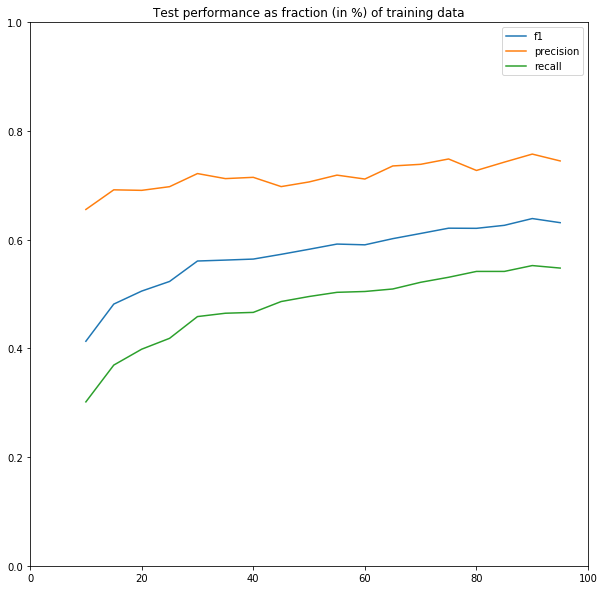

In [55]:
df = pd.DataFrame(scores, index=range(10, 100, 5)).drop('jaccard', axis=1)
df.plot(title='Test performance as fraction (in %) of training data',
            ylim=(0,1), xlim=(0, 100),
           figsize=(10, 10));

### Summary
- The baseline model of predicting the most common term has a very bad performance (~0.013 F1).
- The model based approaches significantly out-performs the most_common baseline and the keyword-based approach as measured on the test set.
- The Spacy model has the highest recall, but a very low precision. In practice, this would manifest itself with a high rate of false alarms (quantity is good, quality not so much).
- The Spacy approach is even weaker than the naive keywords-based approach.
- Combining the the model-based approach together with the keywords did not give a boost as expected. F1 performance dropped, with only a small improvement in recall
- Conditional Random Fields (CRF) has the best overall performance and is only beaten by Spacy on recall.


### Notes

- The model based and the keyword based approaches would profit from more training data.
- There are ~4000 reviews with labeled data available (trainig + test set) which is on not a lot. Gathering more data would most likely improve performance, but only by a small amount.
- The Spacy approach would not improve with more available training data.

### Summary and Results

We have explored different ways of tackling the problem of "Aspect Term Extraction". 

We tried four different algorithms:

- Keyword-based approach based using just the training corpus
- Dependency parsing using noun-chunks extraction using the Spacy library
- Model-based approaches on hand-crafted features using
  * Logistic Regression
  * Conditional Random Fields

We discussed the strength and weaknesses of these algorithms and evaluated their performance under our chosen performance metric.

### Areas for further exploration

##### Improvements to the current model
- Incorporate POS tagging as part of the feature engineering (type of previous token). The current approach is non-iterative (e.g. we disregard predictions on preceeding tokens)
- Add stop word removal for the LogisticRegression and CRF model
- Better tokenization and sanitization of input
- Apply stemming and lemmatization
- Expose the Model as a ReST-API for further consumption by end-users
- Acquire and use more data for training
- Feature Elimination using less predictive features
- Perform hyper-parameter optimization using n-fold cross-validation
- Topic Modelling using LDA

##### Deep Learning
- Long-short term memory (LSTM) neural networks
- Embeddings with word2vec